<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/hindcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs
dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps' #where to save heatmaps

In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3

     |████████████████████████████████| 1.0MB 5.9MB/s 
     |████████████████████████████████| 14.8MB 405kB/s 
     |████████████████████████████████| 6.5MB 52.1MB/s 
     |████████████████████████████████| 4.7MB 5.6MB/s 
     |████████████████████████████████| 317kB 31.6MB/s 
     |████████████████████████████████| 614kB 5.8MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm#, colors, path
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression

import pickle
import os
from random import seed
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


nan

In [5]:
#define functions

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def rmse(y_model, y_obs):

  RMSE = np.sqrt( np.nanmean( (y_model - y_obs)**2 ) )

  return RMSE

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

# Prep data: 1979 - 2015

In [6]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
# flowpickle = ['BC_flowvars_1979_2015.pickle', 'AB_flowvars_1979_2015.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
# pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
# tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
# pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
# precDict = pickle.load(pickle_in)

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_modern = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [7]:
#select subset of stations

maxLat = 56. #maximum station latitude to include
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0]) #indices of stations which are below maximum latitude

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude

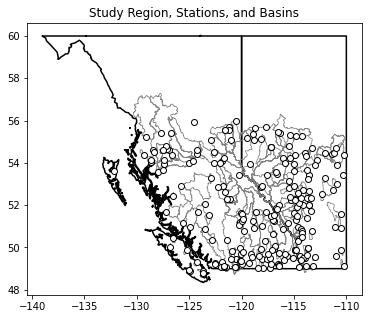

In [8]:
#visualize study region
fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'gray', linewidth = 0.75)
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', zorder = 3)
ax.set_title('Study Region, Stations, and Basins')

plt.show()

In [9]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  #trim temp/precip data to only those values within bounding box
  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [10]:
#standardize data relative to training time period

#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

In [11]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_val = np.empty((Nval, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,), dtype = np.float16)
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#training
for ii in range(Ntrain-365):
  x_train[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)
x_train = tf.convert_to_tensor(x_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)
y_train = tf.convert_to_tensor(y_train)

In [12]:
stationNames = flowDict['stationName'][stationInds]

# Cluster seasonal flow: 1979 - 2015

In [227]:
#create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds), len_input))

flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

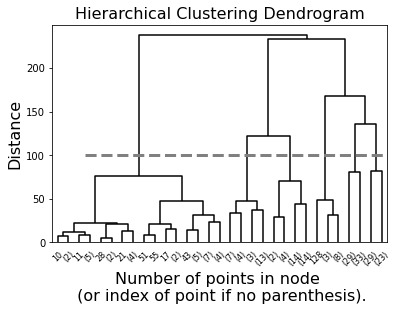

In [228]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [229]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [230]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern'
]

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

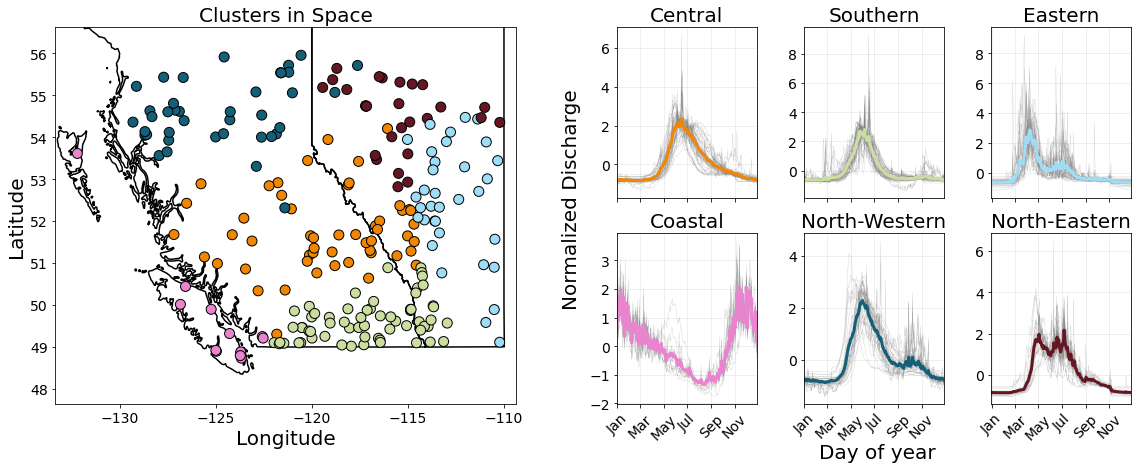

In [231]:
#visualize clustering results (spatial + temporal patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig = plt.figure(figsize = (16,7))

#left side: spatial map of stations, coloured by cluster to which they belong
ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-6)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))

#right side: subplots of seasonal streamflow of each cluster 
subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

ax0.text(-107,50, 'Normalized Discharge', fontsize = fs, rotation = 90) #manually add axis labels to control tight-layout aesthetic 
ax0.text(-93.6,46.35, 'Day of year', fontsize = fs)

if saveIt:
  plt.savefig('cluster_patterns.png', bbox_inches = 'tight', dpi = 200)

if saveEPS:
  plt.savefig('cluster_patterns.eps', format = 'eps', bbox_inches='tight')

plt.show()

# Predict streamflow: 1979 - 2015

In [18]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  y_train_predict_fine_runs[ii,:,:] = y_train_predict_fine
  y_val_predict_fine_runs[ii,:,:] = y_val_predict_fine
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine

  # # HERE: Predict flow, rather than load flow
  # for cluster in range(n_clusters_seasonal):
    
  #   print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

  #   stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
  #   N_stations = len(stations_fine) #number of stations in this cluster

  #   # load model
  #   model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
  #   model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

  #   y_train_intermediate = model_fine.predict(x_train, verbose = 0)
  #   y_val_intermediate = model_fine.predict(x_val, verbose = 0)
  #   y_test_intermediate = model_fine.predict(x_test, verbose = 1)

  #   for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
  #       y_train_predict_fine_runs[run,:,station] = y_train_intermediate[:,zz]
  #       y_val_predict_fine_runs[run,:,station] = y_val_intermediate[:,zz]
  #       y_test_predict_fine_runs[run,:,station] = y_test_intermediate[:,zz]

  

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [19]:
y_train_ensemble_predict = np.mean(y_train_predict_fine_runs, axis = 0)
y_val_ensemble_predict = np.mean(y_val_predict_fine_runs, axis = 0)
y_test_ensemble_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_modern_predict = np.vstack([y_train_ensemble_predict, y_val_ensemble_predict, y_test_ensemble_predict])

# Prep data: 1950 - 1978 Hindcast

In [20]:
#first, delete high-memory old data
del x_train, x_val, x_test, y_train, y_val, y_test

In [21]:
#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

In [22]:
#restrict to region of interest determined above
Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

In [23]:
#standardize data relative to training time period

#years/indices of hindcast
hindStartYear = 1950
hindFinYear = 1978

hindInds = np.arange(len(eraDays)-1)
Nhind = len(hindInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

In [24]:
Tminnorm = Tminnorm[:-1]
Tmaxnorm = Tmaxnorm[:-1]

In [25]:
#construct train and test predictor tensors

#predictor data
nchannels = 3 
x_hind = np.empty((Nhind-365,365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Pnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#hindcast
for ii in range(Nhind-365):
  x_hind[ii] = x_intermediate[ii:ii+365]

#convert predict/target arrays to tensors
x_hind = tf.convert_to_tensor(x_hind)

# Predict streamflow: 1950 - 1978

In [ ]:
#predict and save streamflow hindcast data

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0]

#initialize
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds))) #fine-tuned model predictions of each run
y_hind_predict_fine = np.empty((Nhind-365, len(stationInds))) #fine-tuned model predictions of each run

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  for cluster in range(n_clusters_seasonal):
    
    print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster

    #load model
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

    y_hind_intermediate = model_fine.predict(x_hind, verbose = 0)

    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        # y_hind_predict_fine_runs[run,:,station] = y_hind_intermediate[:,zz]
        y_hind_predict_fine[:,station] = y_hind_intermediate[:,zz]

  #save fine-tuned model predictions
  file_hind = 'y_hind_fine_predict_' + str(ii) + '.csv'
  np.savetxt(dir_output + '/' + file_hind, y_hind_predict_fine, delimiter = ',')


Run 0
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 1
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 2
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 3
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 4
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 5
Fine model, cluster 1 / 6
Fine model, cluster 2 / 6
Fine model, cluster 3 / 6
Fine model, cluster 4 / 6
Fine model, cluster 5 / 6
Fine model, cluster 6 / 6
Run 6
Fine model, cluster 1 

# Load streamflow: 1950 - 2015

In [26]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  filename_hind_fine = 'y_hind_fine_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  y_hind_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_hind_fine, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  y_hind_predict_fine_runs[ii,:,:] = y_hind_predict_fine
  y_train_predict_fine_runs[ii,:,:] = y_train_predict_fine
  y_val_predict_fine_runs[ii,:,:] = y_val_predict_fine
  y_test_predict_fine_runs[ii,:,:] = y_test_predict_fine

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [27]:
y_hind_predict = np.mean(y_hind_predict_fine_runs, axis = 0)
y_train_predict = np.mean(y_train_predict_fine_runs, axis = 0)
y_val_predict = np.mean(y_val_predict_fine_runs, axis = 0)
y_test_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_modern_predict = np.vstack([y_train_predict, y_val_predict, y_test_predict])

y_hind_std = np.std(y_hind_predict_fine_runs, axis = 0)
y_train_std = np.std(y_train_predict_fine_runs, axis = 0)
y_val_std = np.std(y_val_predict_fine_runs, axis = 0)
y_test_std = np.std(y_test_predict_fine_runs, axis = 0)
y_modern_std = np.vstack([y_train_std, y_val_std, y_test_std])



# Load observations: 1950 - 2015

In [180]:
flowpickle = ['BC_flowvars_1950_2015_missing_10_10_0.pickle', 'AB_flowvars_1950_2015_missing_10_10_0.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict_long = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat_long = flowDict_long['stationLat']
stationLon_long = flowDict_long['stationLon']

flowDays_long = flowDict_long['windowDays']
flowMonths_long = flowDict_long['windowMonths']
flowYears_long = flowDict_long['windowYears']

date_str = [str(int(flowDays_long[kk])) + '-' +  str(int(flowMonths_long[kk])) + '-' + str(int(flowYears_long[kk])) for kk in range(len(flowYears_long))]
flowDate_long = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F_long = np.squeeze(flowDict_long['all_flow'])
stationNames_long = flowDict_long['stationName']


In [181]:
#ELK: 109
#BANFF: 141
#PEMBINA:
#CHEMAINUS: 31
#PEMBINA: 206
ind = 206
stationName = stationNames[ind]

ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
ind_long

array(447)

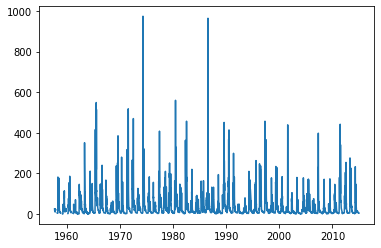

In [182]:
plt.plot(flowDate_long, F_long[ind_long,:])

ValueError: ignored

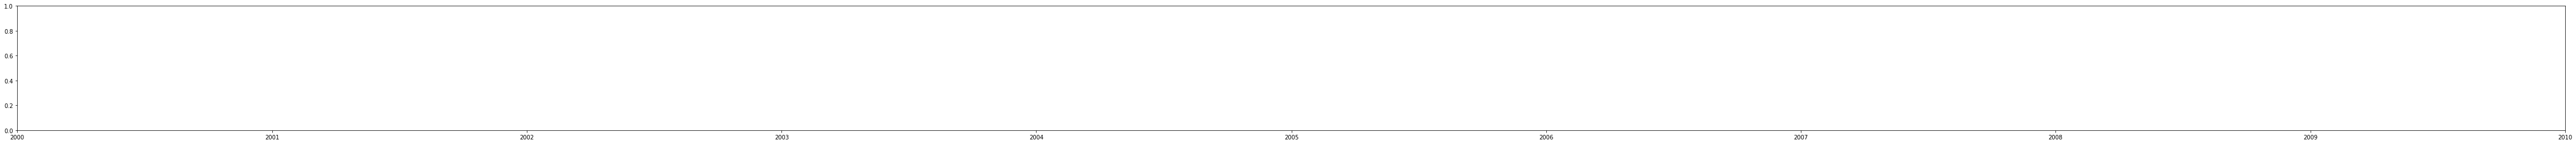

In [183]:
saveIt = 0

# ind = 141 #141 is bow at banff
rgb = '#1f77b4' #colour for shading that I like (picked from coolors.co)
rgb_mod = '#CF9893'

fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (80,4))

fb_hind1 = y_hind_predict[:,ind] - 2*y_hind_std[:,ind]
fb_hind2 = y_hind_predict[:,ind] + 2*y_hind_std[:,ind]

fb_mod1 = y_modern_predict[:,ind] - 2*y_modern_std[:,ind]
fb_mod2 = y_modern_predict[:,ind] + 2*y_modern_std[:,ind]

#hindcast model
ax.plot(eraDate_hind[365:-1], y_hind_predict[:,ind], label = 'Hindcast', color = rgb, linewidth = 1)
ax.fill_between(eraDate_hind[365:-1], fb_hind1, fb_hind2, alpha = 0.3, label = '2\u03C3 interval', color = rgb)

#modern model
ax.plot(eraDate_modern[365:], y_modern_predict[:,ind], label = 'Modern', color = rgb_mod, linewidth = 1)
ax.fill_between(eraDate_modern[365:], fb_mod1, fb_mod2, alpha = 0.3, color = rgb_mod)

#entire observation
ax.plot(flowDate_long, (F_long[ind_long,:] - Fmean[ind]) / Fstd[ind], 'k', label = 'Observations', zOrder = 0)

ax.set_ylabel('Normalized Streamflow', fontsize = fs)
ax.set_xlabel('Day', fontsize = fs)
ax.set_title(stationNames[ind])
ax.legend(fontsize = fs-4)

# ax.set_xlim((
#     datetime(2001,1,1),
#     datetime(2009,1,1)
# ))

if saveIt:
  plt.savefig(stationNames[ind] + '_hind_modern.png', bbox_inches = 'tight', dpi = 250)

In [184]:
#fraction missing data during period 1950 - 1978
hind_missing = np.zeros(len(stationInds))
start = flowDate_long.index(datetime(1951,1,1))
fin = flowDate_long.index(datetime(1978,12,31))
for kk, stationName in enumerate(stationNames):
  ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
  Nnan = len(np.argwhere(np.isnan(F_long[ind_long,start:fin])))
  Ndays = len(F_long[ind_long,start:fin])
  hind_missing[kk] = Nnan / Ndays

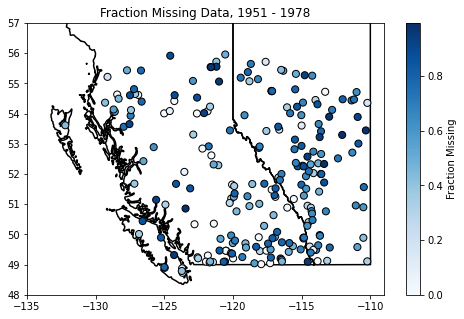

In [186]:
saveIt = 0

fig, ax = plt.subplots(figsize = (8,5))
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = hind_missing, cmap = 'Blues', linewidth = 1, edgecolor = 'k', s = 50, zOrder = 3)
plot_prov_ax(prov, ax)
cb = plt.colorbar(s)
cb.set_label('Fraction Missing')
ax.set_title('Fraction Missing Data, 1951 - 1978')
ax.set_xlim((-135,-109))
ax.set_ylim((48,57))

if saveIt:
  plt.savefig('frac_missing_hindcast.png', bbox_inches = 'tight', dpi = 150)

plt.show()

In [166]:
hind_missing[141] < 5/28

True

# Evaluate model performance

In [39]:
eraDate_hind = eraDate_hind[365:]
eraDate_modern = eraDate_modern[365:]

In [187]:
start_obs = flowDate_long.index(datetime(1951,1,1))
fin_obs = flowDate_long.index(datetime(1978,12,31))

start_model = eraDate_hind.index(datetime(1951,1,1))
fin_model = eraDate_hind.index(datetime(1978,12,31))

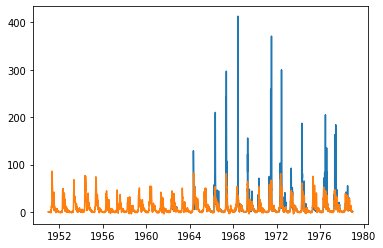

In [188]:
dd = np.array(eraDate_hind[start_model:fin_model])
station = 8
stationName = stationNames[station]
station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

y_obs = F_long[station_long ,start_obs:fin_obs]
y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

plt.plot(dd, y_obs)
plt.plot(dd, y_model)

In [196]:
len(np.argwhere(hind_missing < 23/28))
# 5/28

181

In [197]:
len(stationInds)

226

In [198]:
len(hind_missing)

226

In [421]:
# a = np.intersect1d(good_snow_inds, full_stations)

In [422]:
len(a)

149

In [420]:
len(full_stations)

181

In [214]:
NSE_hind = np.zeros(len(stationInds))
NSE_modern = np.zeros(len(stationInds))

frac_max_missing_data = 23/28
full_stations = np.squeeze(np.argwhere(hind_missing < frac_max_missing_data))

for station in range(len(stationInds)):

  if hind_missing[station] < frac_max_missing_data:
    # print(station)

    stationName = stationNames[station]
    station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

    ### hindcast NSE

    start_obs = flowDate_long.index(datetime(1951,1,1))
    fin_obs = flowDate_long.index(datetime(1978,12,31))

    start_model = eraDate_hind.index(datetime(1951,1,1))
    fin_model = eraDate_hind.index(datetime(1978,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[station_long ,start_obs:fin_obs]
    y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_hind[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])
    
    ### modern NSE

    start_obs = flowDate_long.index(datetime(1980,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(1980,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    start_obs = flowDate_long.index(datetime(2011,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(2011,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[station_long ,start_obs:fin_obs]
    y_model = y_modern_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_modern[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])

dNSE = NSE_hind - NSE_modern

In [423]:
good_snow_inds = np.argwhere(
    (seasonal_clustering.labels_ != 2) &
    (seasonal_clustering.labels_ != 3)
)

full_stations = np.intersect1d(good_snow_inds, full_stations)

In [216]:
len(full_stations)

181

(-0.25, 1.0)

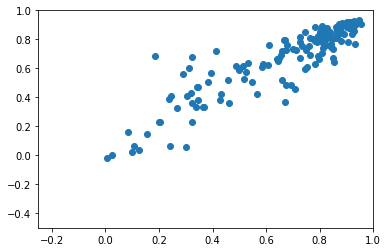

In [424]:
plt.scatter(NSE_modern[full_stations], NSE_hind[full_stations])
plt.ylim((-0.5,1))
plt.xlim((-0.25, 1))

(-0.24584790702348291, 0.4980981348584196)

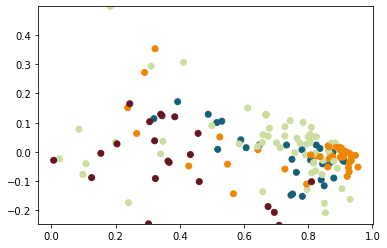

In [425]:
plt.scatter(NSE_modern[full_stations], dNSE[full_stations], c = cStations[full_stations])
plt.ylim((np.sort(dNSE[full_stations])[2], np.max(dNSE[full_stations])))

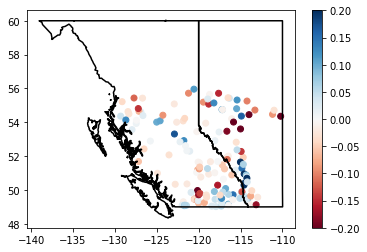

In [426]:
fig, ax = plt.subplots()
plot_prov_ax(prov = prov, ax = ax)
s = ax.scatter(stationLon[stationInds][full_stations], stationLat[stationInds][full_stations], c = dNSE[full_stations], cmap = 'RdBu', vmin = -0.2, vmax = 0.2)#vmin = -0.5, vmax = 1, )
fig.colorbar(s)

(0.0, 5.272315618425092)

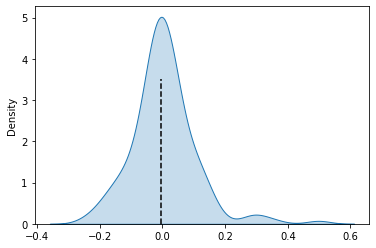

In [428]:
xx = np.sort(dNSE[full_stations])[2:]
dNSE_median = np.median(dNSE[full_stations])

fig, ax = plt.subplots()
kde = sns.kdeplot(xx, ax = ax, shade = True, color = rgb)
ax.plot([dNSE_median,dNSE_median],[0, 3.5], 'k--')
# ax.plot(dNSE_median * np.ones(2), np.array([0,3.5]))
ax.set_ylim(bottom = 0)

(0.0, 1.8997720266214633)

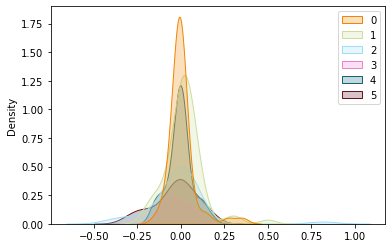

In [429]:
fig, ax = plt.subplots()
kde = sns.kdeplot(dNSE, ax = ax, shade = True, hue = seasonal_clustering.labels_, palette = list(rgbas_array))
# ax.plot([dNSE_median,dNSE_median],[0, 3.5], 'k--')
# ax.plot(dNSE_median * np.ones(2), np.array([0,3.5]))
ax.set_ylim(bottom = 0)

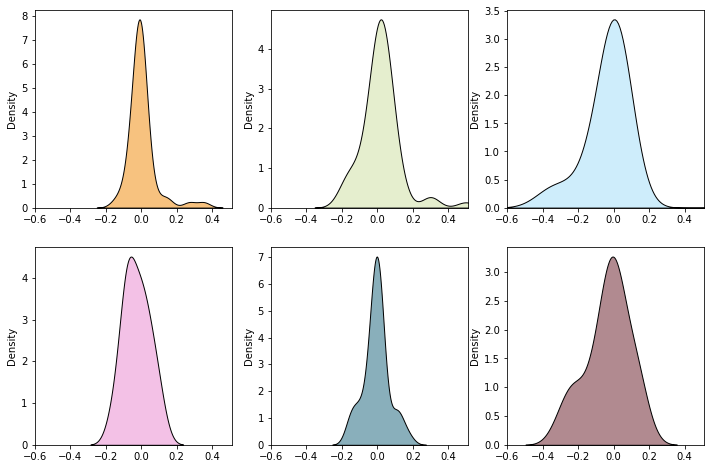

In [442]:
nrows = 2
ncols = 3

fix, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  kde = sns.kdeplot(dNSE[cluster_inds], ax = ax, color = rgbas_array[cluster,:], fill = True, alpha = 0.5, edgecolor = 'k')
  ax.set_xlim((-0.6,0.51))


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


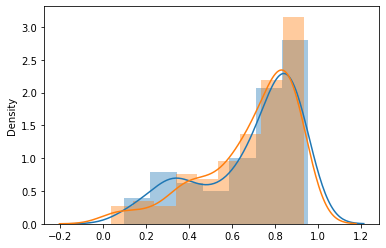

In [443]:
sns.distplot(NSE_modern[full_stations][NSE_modern[full_stations]>np.sort(NSE_modern[full_stations])[2]])
sns.distplot(NSE_hind[full_stations][NSE_hind[full_stations]>np.sort(NSE_hind[full_stations])[2]])

In [444]:
np.median(xx)

-0.004707195234837647

In [445]:
np.std(xx)

0.10243099476676318

In [446]:
len(np.argwhere(np.abs(dNSE)<0.1)) / len(dNSE)

0.7787610619469026

# Trend in freshet: Model

In [117]:
y_predict = np.vstack([y_hind_predict, y_modern_predict])
eraDate = list(np.hstack([eraDate_hind, eraDate_modern]))
stations = range(len(stationInds))

In [447]:
#calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

Nyears = int(len(y_predict)/365)
Nstations = len(stations)

q_peak = np.zeros((Nyears,Nstations))
t_peak = np.zeros((Nyears,Nstations))
t_half = np.zeros((Nyears,Nstations))

for kk, station in enumerate(stations):
  year = 1951
  for hh in range(Nyears):

    if year != 1979:

      start = datetime(year,1,1)
      fin = start + timedelta(365)
      start_ind = eraDate.index(start)
      if (year == 1978) | (year == 2015):
        fin = start + timedelta(364)
      fin_ind = eraDate.index(fin)

      q = np.squeeze(y_predict[start_ind:fin_ind, station])
      q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
      q -= np.min(q)

      maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
      maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
      maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
      if len(maxima_ind.reshape(-1,1)) == 0:
        maxima_ind = np.argmax(q)

      t_peak[hh,kk] = np.min(maxima_ind)

      q_peak[hh,kk] = q[int(t_peak[hh,kk])]
      qq = q - 0.5*q_peak[hh,kk]
      t_half[hh,kk] = np.min(np.argsort(np.abs(qq))[:10])#np.min(np.argwhere(np.abs(qq) < 0.1))

    year+=1

In [448]:
t_half = np.delete(t_half, 28, 0)
t_peak = np.delete(t_peak, 28, 0)

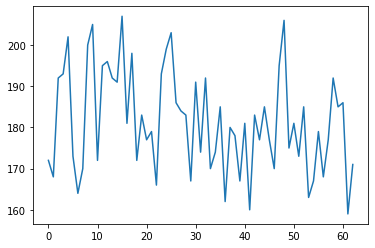

In [449]:
plt.plot(t_peak[:,141])

In [450]:
np.shape(t_peak)

(63, 226)

In [122]:
#create cluster input

cluster_input = t_peak.T
cluster_input = t_half.T

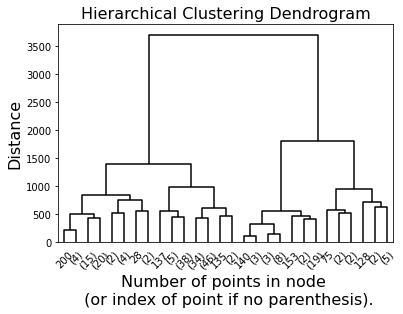

In [123]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
# cutoff = 100
# linemin = 30
# linemax = 310
# plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [124]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 3
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [197]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

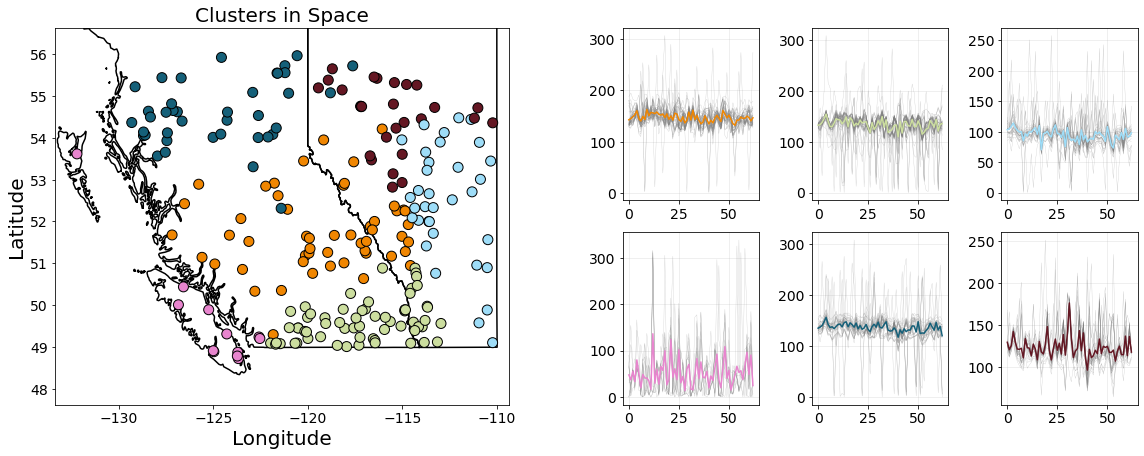

In [455]:
#visualize clustering results (spatial + temporal patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig = plt.figure(figsize = (16,7))

#left side: spatial map of stations, coloured by cluster to which they belong
ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = fs-6)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)
ax0.set_xlim((extentERA[0], extentERA[1]))
ax0.set_ylim((extentERA[2], extentERA[3]))

#right side: subplots of seasonal streamflow of each cluster 
subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  # ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  # ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.plot(np.mean(t_half[:,cluster_inds], axis = 1), color = rgbas_array[cluster,:])
  ax.tick_params(labelsize = fs - 6)
  ax.grid(True, alpha = 0.25)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if saveIt:
  plt.savefig('cluster_patterns.png', bbox_inches = 'tight', dpi = 200)

if saveEPS:
  plt.savefig('cluster_patterns.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [460]:
freshet_trend_mod = np.zeros(len(stationInds))

for station in range(len(stationInds)):
  yy = t_half[:,station].reshape(-1,1)
  xx = np.arange(len(yy)).reshape(-1,1)
  lm = LinearRegression().fit(X = xx, y = yy)
  freshet_trend_mod[station] = lm.coef_

(array([ 3.,  1.,  2.,  2., 36., 83., 15.,  6.,  0.,  1.]),
 array([-0.77054531, -0.65295219, -0.53535906, -0.41776594, -0.30017281,
        -0.18257969, -0.06498656,  0.05260657,  0.17019969,  0.28779282,
         0.40538594]),
 <a list of 10 Patch objects>)

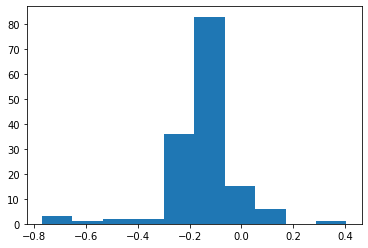

In [469]:
plt.hist(freshet_trend_mod[full_stations])

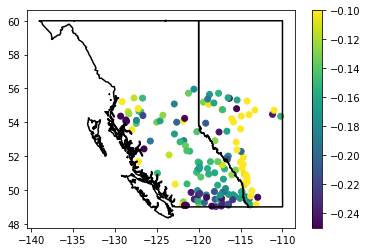

In [477]:
vmin = -0.25#np.sort(freshet_trend_mod)[1]
vmax = -0.1


fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
plt.scatter(stationLon[stationInds][full_stations], stationLat[stationInds][full_stations], c = freshet_trend_mod[full_stations], vmin = vmin, vmax = vmax)
plt.colorbar()

# Trend in freshet: Observations

In [241]:
F_long = np.squeeze(np.asarray(flowDict_long['all_flow'])).T

In [242]:
np.shape(F_long)

(24106, 567)

In [243]:
stations = range(len(stationInds))

In [244]:
#select just the same stations in long-term observations as those in modern period

stationInds_long = np.empty(len(stationInds), dtype = int)
for station in stations:
  stationName = stationNames[station]
  # print(np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long])))
  stationInds_long[station] = int(np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long])))

F_long = F_long[:,stationInds_long]

In [246]:
#calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

years = int(len(F_long)/365)
Nstations = len(stations)
Nstations = len(stationInds)

q_peak_obs = np.zeros((Nyears,Nstations))
t_peak_obs = np.zeros((Nyears,Nstations))
t_half_obs = np.zeros((Nyears,Nstations))

# for kk, station in enumerate(stations):
# for kk, station in enumerate(stationInds):
for station in stations:

  if hind_missing[station] < frac_max_missing_data:

    year = 1951
    
    for hh in range(Nyears):

      if year != 1979:

        start = datetime(year,1,1)
        fin = start + timedelta(365)
        start_ind = flowDate_long.index(start)
        if (year == 1978) | (year == 2015):
          fin = start + timedelta(364)
        fin_ind = flowDate_long.index(fin)

        q = np.squeeze(F_long[start_ind:fin_ind, station])
        q = q[1:]
        q -= np.mean(q)
        q /= np.std(q)
        q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
        q -= np.min(q)

        # maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
        # maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
        # print(len(q[maxima_ind]))
        # # maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
        # if len(maxima_ind.reshape(-1,1)) == 1:#0:
        #   maxima_ind = np.argmax(q)
        # else:
        #   maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]

        maxima_ind = np.argmax(q)

        t_peak_obs[hh,station] = np.min(maxima_ind)

        q_peak_obs[hh,station] = q[int(t_peak_obs[hh,station])]
        qq = q - 0.5*q_peak_obs[hh,station]
        t_half_obs[hh,station] = np.min(np.argsort(np.abs(qq))[:10])#np.min(np.argwhere(np.abs(qq) < 0.2))

      year+=1

In [247]:
#set missing years from 0 to nan
for station in stations:
  t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

In [248]:
t_half_obs = np.delete(t_half_obs, 28, 0)
t_peak_obs = np.delete(t_peak_obs, 28, 0)

In [249]:
years_long = np.delete(np.arange(1951, 2015), 28, 0)


In [250]:
len(years_long)

63

In [251]:
np.shape(t_half_obs), np.shape(t_half)

((63, 226), (63, 226))

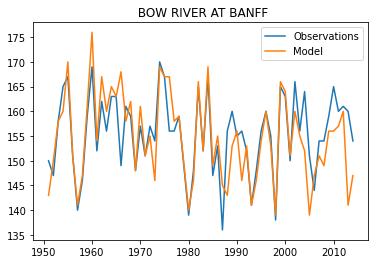

In [252]:
station = 141
stationName = stationNames[station]
# station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

plt.plot(years_long, t_half_obs[:,station], label = 'Observations')
plt.plot(years_long, t_half[:,station], label = 'Model')
plt.title(stationName)
plt.legend()


In [253]:
df = pd.DataFrame({'x' : t_half_obs[:,station], 'y' : t_half[:,station]})
corr = df.corr()['x']['y']
corr

0.7715752723727225

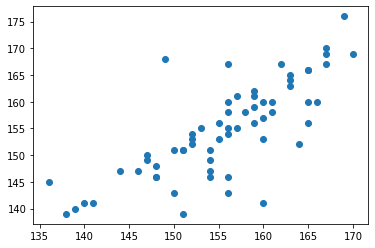

In [254]:
plt.scatter(t_half_obs[:,station], t_half[:,station])
# plt.xlim((125,175))

In [255]:
t_half_obs

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan, 142.,  nan, ...,  nan, 159.,  nan],
       [ nan, 133.,  nan, ...,  nan, 124.,  nan],
       [ nan, 137.,  nan, ...,  nan, 116.,  nan]])

In [256]:
NSE_hind[station], NSE_modern[station]

(0.8821315314442681, 0.8646388611780993)

In [257]:
np.shape(y_predict),np.shape(F_long)

((23375, 226), (24106, 226))

(-1.0, 4.0)

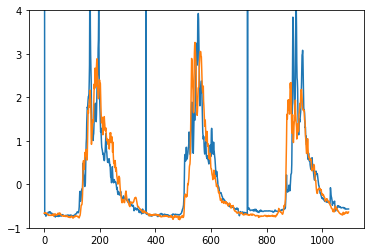

In [258]:
yr = 3

plt.plot(F_long[(yr)*365:(yr+3)*365,station])
plt.plot(y_predict[yr*365:(yr+3)*365,station])
plt.ylim((-1,4))


In [260]:
# calculate hindcast and modern correlations between measured/modelled freshet time

freshet_corr_hind = np.zeros(len(stationInds))
freshet_corr_modern = np.zeros(len(stationInds))

Nyears_hind = len(range(1951,1979))
Nyears_modern = len(range(1980,2016))

for station in stations:

  if hind_missing[station] < frac_max_missing_data:

    df = pd.DataFrame({'x' : t_half_obs[:Nyears_hind, station], 'y' : t_half[:Nyears_hind, station]})
    freshet_corr_hind[station] = df.corr()['x']['y']

    df = pd.DataFrame({'x' : t_half_obs[Nyears_hind:, station], 'y' : t_half[Nyears_hind:, station]})
    freshet_corr_modern[station] = df.corr()['x']['y']

d_freshet = freshet_corr_hind - freshet_corr_modern

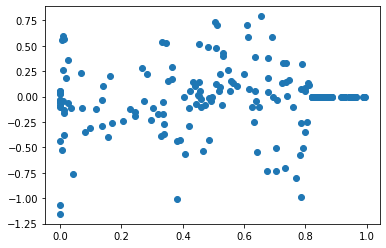

In [261]:
plt.scatter(hind_missing, d_freshet)

In [265]:
a = np.squeeze(np.argwhere(np.isnan(cc)))
hind_missing[a]

array([0.66839429, 0.70643458, 0.68501858, 0.68628985, 0.78036378,
       0.31586153, 0.42450616, 0.54439664, 0.2947389 , 0.66125562,
       0.32652063, 0.70506552, 0.66555838, 0.66017993, 0.60150597,
       0.66330921, 0.47516135, 0.80813612, 0.66086446, 0.59886564,
       0.78398201, 0.70408762, 0.65030315, 0.72129865, 0.76413065,
       0.72980638, 0.8063759 , 0.74144338, 0.72002738, 0.6722081 ,
       0.61734794, 0.5165265 , 0.79170741, 0.70927049, 0.73420692,
       0.77576765, 0.72227655, 0.772345  , 0.32221788])

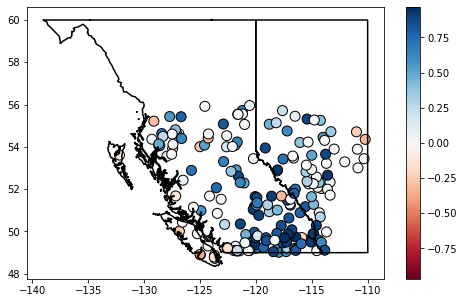

In [262]:
fig, ax = plt.subplots(figsize = (8,5))

cc = freshet_corr_hind
# cc = d_freshet

vmax = np.nanmax(np.abs(cc))
vmin = -vmax

plot_prov_ax(prov, ax)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = cc, s = 100, cmap = 'RdBu', edgecolor = 'k', vmin = vmin, vmax = vmax)
plt.colorbar()

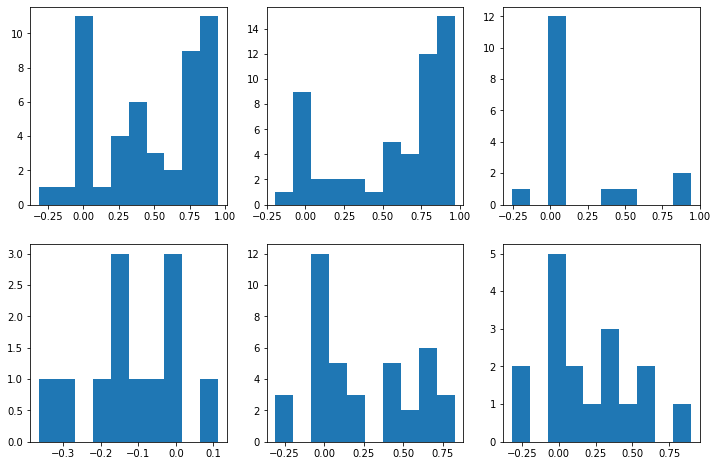

In [268]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  # sns.kdeplot(freshet_corr_modern[cluster_inds], ax = ax)
  ax.hist(freshet_corr_hind[cluster_inds])
  # sns.kdeplot(d_freshet[cluster_inds], ax = ax)

In [272]:
t_half_obs[:,0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

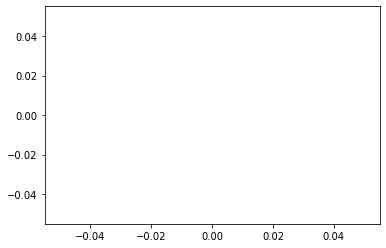

In [269]:
plt.plot(t_half_obs[:,0])

In [490]:
freshet_trend_obs = np.zeros(len(stationInds))

for station in range(len(stationInds)):
  yy = t_half_obs[:,station].reshape(-1,1)
  yy = yy[np.squeeze(np.argwhere(-1*np.isnan(yy)))].reshape(-1,1)
  xx = np.arange(len(yy)).reshape(-1,1)
  lm = LinearRegression().fit(X = xx, y = yy)
  freshet_trend_mod[station] = lm.coef_

ValueError: ignored

array([[ True]])

(array([ 3.,  1.,  2.,  2., 36., 83., 15.,  6.,  0.,  1.]),
 array([-0.77054531, -0.65295219, -0.53535906, -0.41776594, -0.30017281,
        -0.18257969, -0.06498656,  0.05260657,  0.17019969,  0.28779282,
         0.40538594]),
 <a list of 10 Patch objects>)

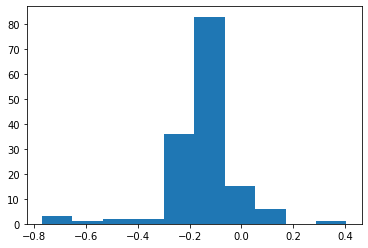

In [ ]:
plt.hist(freshet_trend_mod[full_stations])

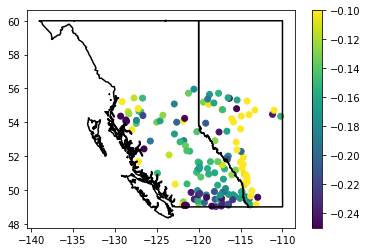

In [ ]:
vmin = -0.25#np.sort(freshet_trend_mod)[1]
vmax = -0.1


fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
plt.scatter(stationLon[stationInds][full_stations], stationLat[stationInds][full_stations], c = freshet_trend_mod[full_stations], vmin = vmin, vmax = vmax)
plt.colorbar()

# Check hydrological indices

In [273]:
#plan: evaluate set of indices over modern period as well as hind casted period -- see if they are substantially different
#goal: want stations where hindcast is not much different than modern

In [274]:
F_long = np.squeeze(flowDict_long['all_flow']).T

In [275]:
np.shape(F_long)

(24106, 567)

In [276]:
#total yearly flow

total_flow_modern = np.zeros((36,len(stationInds)))
total_flow_hind = np.zeros((28,len(stationInds)))

total_flow_modern_model = np.zeros((36,len(stationInds)))
total_flow_hind_model = np.zeros((28,len(stationInds)))

for station in range(len(stationInds)):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### hindcast

  #un-normalize
  F_hind_predict = y_hind_predict[:,station]*Fstd[station] + Fmean[station]
  F_hind = F_long[:, station_long]

  #total yearly flow
  for kk, year in enumerate(range(1951,1979)):

    start = datetime(year, 1, 1)
    fin = start + timedelta(days=364)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_hind.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_hind.index(fin)

    total_flow_hind_model[kk, station] = np.nansum(F_hind_predict[start_mod:fin_mod])
    total_flow_hind[kk,station] = np.nansum(F_hind[start_obs:fin_obs])

### modern

  #un-normalize
  F_modern_predict = y_modern_predict[:,station]*Fstd[station] + Fmean[station]
  F_modern = F_long[:, station_long]

  #total yearly flow
  for kk, year in enumerate(range(1980,2016)):
    
    start = datetime(year, 1, 1)
    fin = start + timedelta(days=364)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_modern.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_modern.index(fin)

    # print(F_modern[start_obs:fin_obs])
    total_flow_modern_model[kk, station] = np.nansum(F_modern_predict[start_mod:fin_mod])
    total_flow_modern[kk,station] = np.nansum(F_modern[start_obs:fin_obs])

total_flow = np.vstack([total_flow_hind, total_flow_modern])
total_flow_model = np.vstack([total_flow_hind_model, total_flow_modern_model])

In [277]:
#total JAS flow

JAS_flow_modern = np.zeros((36,len(stationInds)))
JAS_flow_hind = np.zeros((28,len(stationInds)))

JAS_flow_modern_model = np.zeros((36,len(stationInds)))
JAS_flow_hind_model = np.zeros((28,len(stationInds)))

for station in range(len(stationInds)):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### hindcast

  #un-normalize
  F_hind_predict = y_hind_predict[:,station]*Fstd[station] + Fmean[station]
  F_hind = F_long[:, station_long]

  #total yearly flow
  for kk, year in enumerate(range(1951,1979)):

    start = datetime(year, 7, 1)
    fin = datetime(year, 9, 30)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_hind.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_hind.index(fin)

    JAS_flow_hind_model[kk, station] = np.nansum(F_hind_predict[start_mod:fin_mod])
    JAS_flow_hind[kk,station] = np.nansum(F_hind[start_obs:fin_obs])

### modern

  #un-normalize
  F_modern_predict = y_modern_predict[:,station]*Fstd[station] + Fmean[station]
  F_modern = F_long[:, station_long]

  #total yearly flow
  for kk, year in enumerate(range(1980,2016)):
    
    start = datetime(year, 7, 1)
    fin = datetime(year, 9, 30)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_modern.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_modern.index(fin)

    JAS_flow_modern_model[kk, station] = np.nansum(F_modern_predict[start_mod:fin_mod])
    JAS_flow_modern[kk,station] = np.nansum(F_modern[start_obs:fin_obs])

JAS_flow = np.vstack([JAS_flow_hind, JAS_flow_modern])
JAS_flow_model = np.vstack([JAS_flow_hind_model, JAS_flow_modern_model])

In [281]:
np.shape(JAS_flow)

(64, 226)

In [285]:
for station in range(len(stationInds)):
  # nan_inds = np.squeeze(np.argwhere)
  total_flow[total_flow[:,station] == 0,station] = np.nan
  JAS_flow[JAS_flow[:,station] == 0,station] = np.nan

In [298]:
ind = np.squeeze(np.argwhere([name.startswith(' ATHA') for name in stationNames]))
stationNames[ind], ind

(array([' ATHABASCA RIVER NEAR JASPER', ' ATHABASCA RIVER AT HINTON',
        ' ATHABASCA RIVER NEAR WINDFALL', ' ATHABASCA RIVER AT ATHABASCA'],
       dtype=object), array([195, 196, 197, 208]))

In [305]:
ind = np.squeeze(np.argwhere([name.startswith(' BOW RIVER AT L') for name in stationNames]))
ind = 208
stationName = stationNames[ind]
ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

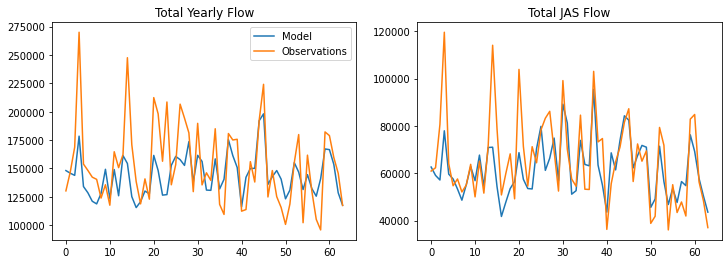

In [306]:
plt.figure(figsize = (12,4))

plt.subplot(121)
plt.plot(total_flow_model[:,ind], label = 'Model')
plt.plot(total_flow[:,ind], label = 'Observations')
plt.title('Total Yearly Flow')
plt.legend()

plt.subplot(122)
plt.plot(JAS_flow_model[:,ind])
plt.plot(JAS_flow[:,ind])
plt.title('Total JAS Flow')

plt.show()

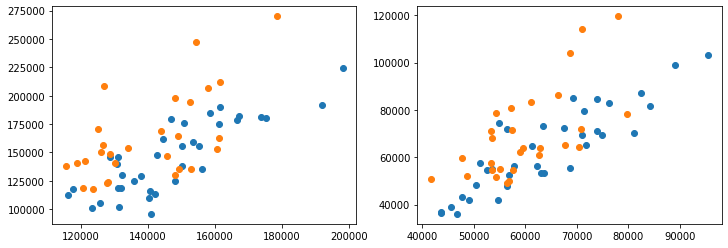

In [307]:
# ind = 141
plt.figure(figsize = (12,4))

plt.subplot(121)
plt.scatter(total_flow_modern_model[:,ind], total_flow_modern[:,ind])
plt.scatter(total_flow_hind_model[:,ind], total_flow_hind[:,ind])

plt.subplot(122)
plt.scatter(JAS_flow_modern_model[:,ind], JAS_flow_modern[:,ind])
plt.scatter(JAS_flow_hind_model[:,ind], JAS_flow_hind[:,ind])

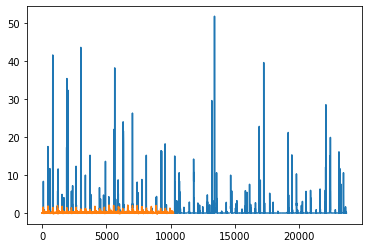

In [308]:
plt.plot(F_hind)
plt.plot(F_hind_predict)

In [309]:
# m = np.array([d.month for d in eraDate_modern])
# inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
# inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
# inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
# inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

def get_seasonal_inds_from_list(date_list):
  m = np.array([d.month for d in date_list])
  inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
  inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
  inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
  inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

  return inds_DJF, inds_MAM, inds_JJA, inds_SON


In [396]:
#RMSE: all time, low flow, and high flow

#by low/high
RMSE_low_modern = np.zeros(len(stationInds))
RMSE_low_hind = np.zeros(len(stationInds))

RMSE_high_modern = np.zeros(len(stationInds))
RMSE_high_hind = np.zeros(len(stationInds))

RMSE_modern = np.zeros(len(stationInds))
RMSE_hind = np.zeros(len(stationInds))

#normalized
# RMSE_low_modern_norm = np.zeros(len(stationInds))
# RMSE_low_hind_norm = np.zeros(len(stationInds))

# RMSE_high_modern_norm = np.zeros(len(stationInds))
# RMSE_high_hind_norm = np.zeros(len(stationInds))

# RMSE_modern_norm = np.zeros(len(stationInds))
# RMSE_hind_norm = np.zeros(len(stationInds))

#by season
RMSE_DJF_modern = np.zeros(len(stationInds))
RMSE_DJF_hind = np.zeros(len(stationInds))

RMSE_MAM_modern = np.zeros(len(stationInds))
RMSE_MAM_hind = np.zeros(len(stationInds))

RMSE_JJA_modern = np.zeros(len(stationInds))
RMSE_JJA_hind = np.zeros(len(stationInds))

RMSE_SON_modern = np.zeros(len(stationInds))
RMSE_SON_hind = np.zeros(len(stationInds))

#R^2
R2_modern = np.zeros(len(stationInds))
R2_hind = np.zeros(len(stationInds))

#calculate RMSE at each station
for station in range(len(stationInds)-1):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### modern

  #time period
  start = datetime(2011, 1, 1)
  fin = datetime(2015,12,31)

  start_obs = flowDate_long.index(start)
  start_mod = eraDate_modern.index(start)

  fin_obs = flowDate_long.index(fin)
  fin_mod = eraDate_modern.index(fin)

  #un-normalize
  F_modern_predict = y_modern_predict[start_mod:fin_mod,station]#*Fstd[station] + Fmean[station]
  F_modern = (F_long[start_obs:fin_obs, station_long] - Fmean[station]) / Fstd[station]

  #low and high flow indices -- defined relative to modern observations
  low_flow_inds = np.argwhere(F_modern < 0.2*np.nanmean(F_modern))
  high_flow_inds = np.argwhere(F_modern > 0.8*np.nanmean(F_modern))

  #calculate RMSE by high/low
  RMSE_modern[station] = rmse(
      y_model = F_modern_predict, 
      y_obs = F_modern
      )
  
  RMSE_low_modern[station] = rmse(
      y_model = F_modern_predict[low_flow_inds], 
      y_obs = F_modern[low_flow_inds]
      )
  
  RMSE_high_modern[station] = rmse(
      y_model = F_modern_predict[high_flow_inds], 
      y_obs = F_modern[high_flow_inds]
      )
  
  #normalized
  # RMSE_modern_norm[station] = RMSE_modern[station] / Fmean[station]
  
  # RMSE_low_modern_norm[station] = RMSE_low_modern[station] / Fmean[station]
  
  # RMSE_high_modern_norm[station] = RMSE_high_modern[station] / Fmean[station]

  #RMSE by season

  inds_DJF_obs_m, inds_MAM_obs_m, inds_JJA_obs_m, inds_SON_obs_m = get_seasonal_inds_from_list(flowDate_long[start_obs : fin_obs])
  inds_DJF_mod_m, inds_MAM_mod_m, inds_JJA_mod_m, inds_SON_mod_m = get_seasonal_inds_from_list(eraDate_modern[start_mod : fin_mod])
  
  RMSE_DJF_modern[station] = rmse(
      y_model = F_modern_predict[inds_DJF_mod_m],
      y_obs = F_modern[inds_DJF_obs_m]
  ) #/ Fmean[station]

  RMSE_MAM_modern[station] = rmse(
      y_model = F_modern_predict[inds_MAM_mod_m],
      y_obs = F_modern[inds_MAM_obs_m]
  ) #/ Fmean[station]

  RMSE_JJA_modern[station] = rmse(
      y_model = F_modern_predict[inds_JJA_mod_m],
      y_obs = F_modern[inds_JJA_obs_m]
  ) #/ Fmean[station]

  RMSE_SON_modern[station] = rmse(
      y_model = F_modern_predict[inds_SON_mod_m],
      y_obs = F_modern[inds_SON_obs_m]
  ) #/ Fmean[station]

  #R^2 -- use pandas because it can easily handle nans
  df = pd.DataFrame({'x': F_modern, 'y': F_modern_predict})
  R2_modern[station] = df.corr()['x']['y']**2

### hindcast

  #time period
  start = datetime(1951, 1, 1)
  fin = datetime(1978,12,31)

  start_obs = flowDate_long.index(start)
  start_mod = eraDate_hind.index(start)

  fin_obs = flowDate_long.index(fin)
  fin_mod = eraDate_hind.index(fin)

  #un-normalize
  F_hind_predict = y_hind_predict[start_mod:fin_mod,station]#*Fstd[station] + Fmean[station]
  F_hind = (F_long[start_obs:fin_obs, station_long] - Fmean[station]) / Fstd[station]

  #low and high flow indices -- defined relative to observations
  low_flow_inds = np.argwhere(F_hind < 0.2*np.nanmean(F_modern))
  high_flow_inds = np.argwhere(F_hind > 0.8*np.nanmean(F_modern))

  RMSE_hind[station] = rmse(
      y_model = F_hind_predict, 
      y_obs = F_hind
      )
  
  RMSE_low_hind[station] = rmse(
      y_model = F_hind_predict[low_flow_inds], 
      y_obs = F_hind[low_flow_inds]
      )
  
  RMSE_high_hind[station] = rmse(
      y_model = F_hind_predict[high_flow_inds], 
      y_obs = F_hind[high_flow_inds]
      )
  
  # RMSE_hind_norm[station] = RMSE_hind[station] / Fmean[station]
  
  # RMSE_low_hind_norm[station] = RMSE_low_hind[station] / Fmean[station]
  
  # RMSE_high_hind_norm[station] = RMSE_high_hind[station] / Fmean[station]

  #RMSE by season

  inds_DJF_obs, inds_MAM_obs, inds_JJA_obs, inds_SON_obs = get_seasonal_inds_from_list(flowDate_long[start_obs : fin_obs])
  inds_DJF_mod, inds_MAM_mod, inds_JJA_mod, inds_SON_mod = get_seasonal_inds_from_list(eraDate_hind[start_mod : fin_mod])
  
  RMSE_DJF_hind[station] = rmse(
      y_model = F_hind_predict[inds_DJF_mod],
      y_obs = F_hind[inds_DJF_obs]
  ) #/ Fmean[station]

  RMSE_MAM_hind[station] = rmse(
      y_model = F_hind_predict[inds_MAM_mod],
      y_obs = F_hind[inds_MAM_obs]
  ) #/ Fmean[station]

  RMSE_JJA_hind[station] = rmse(
      y_model = F_hind_predict[inds_JJA_mod],
      y_obs = F_hind[inds_JJA_obs]
  ) #/ Fmean[station]

  RMSE_SON_hind[station] = rmse(
      y_model = F_hind_predict[inds_SON_mod],
      y_obs = F_hind[inds_SON_obs]
  ) #/ Fmean[station]

  #R^2 -- use pandas because it can easily handle nans
  df = pd.DataFrame({'x': F_hind, 'y': F_hind_predict})
  R2_hind[station] = df.corr()['x']['y']**2

#difference between hindcast and modern
dRMSE = RMSE_hind - RMSE_modern
dRMSE_low = RMSE_low_hind - RMSE_low_modern
dRMSE_high = RMSE_high_hind - RMSE_high_modern
dRMSE_DJF = RMSE_DJF_hind - RMSE_DJF_modern
dRMSE_MAM = RMSE_MAM_hind - RMSE_MAM_modern
dRMSE_JJA = RMSE_JJA_hind - RMSE_JJA_modern
dRMSE_SON = RMSE_SON_hind - RMSE_SON_modern

dR2 = R2_hind - R2_modern

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


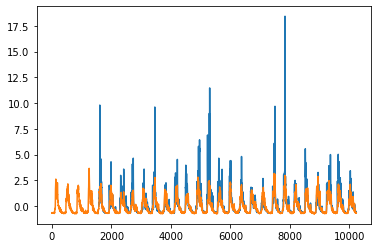

In [397]:
plt.plot(F_hind)#[inds_MAM_obs])
plt.plot(F_hind_predict)#[inds_MAM_mod])
# plt.xlim((0,90))

In [398]:
np.sqrt(np.nanmean((F_hind[inds_MAM_obs] - F_hind_predict[inds_MAM_mod])**2))

0.8416885492293293

In [399]:
np.sqrt(np.nanmean((F_modern[inds_MAM_obs_m] - F_modern_predict[inds_MAM_mod_m])**2))

0.6481963269548358

In [400]:
np.argwhere(RMSE_MAM_modern==0)

array([[225]])

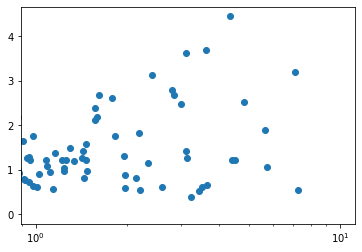

In [401]:
plt.scatter(RMSE_MAM_hind, RMSE_MAM_modern)
plt.xscale('log')

In [402]:
RMSE_MAM_hind[-2], RMSE_MAM_modern[-2]

(0.8416885492293293, 0.6481963269548358)

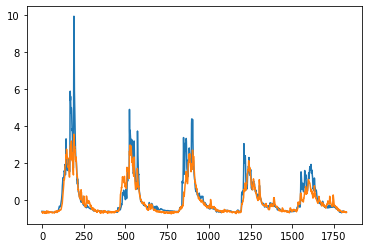

In [403]:
plt.plot(F_modern)#[inds_MAM_obs])
plt.plot(F_modern_predict)#[inds_MAM_mod])
# plt.xlim((60,150))

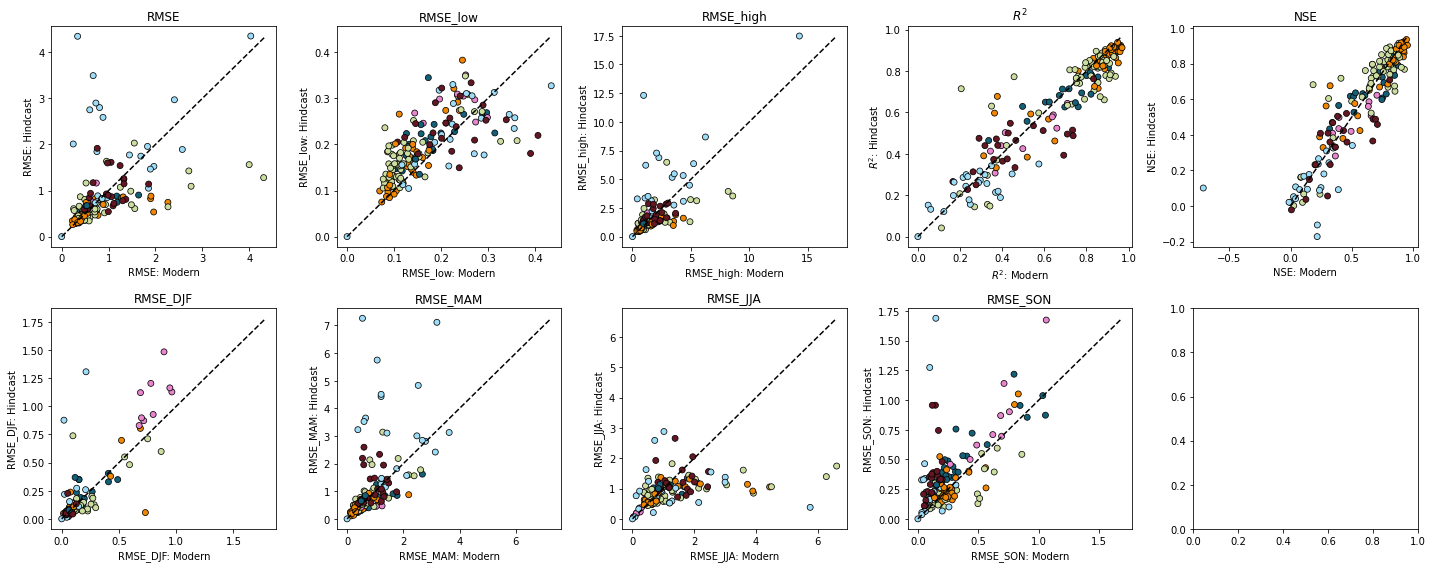

In [404]:
metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_stations]
  yy = metrics[metric][0][full_stations]

  ax = axes.flatten()[kk]

  if metric == 'NSE':
    xx = xx[yy>-10]
    yy = yy[yy>-10]
    ax.scatter(xx, yy, c = cStations[full_stations][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  else:
    ax.scatter(xx, yy, c = cStations[full_stations], edgecolor = 'k', linewidth = 0.75)

  # ax.scatter(xx, yy, c = cStations)
  ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric + ': Modern')
  ax.set_ylabel(metric + ': Hindcast')
  ax.set_title(metric)

plt.tight_layout()

plt.show()

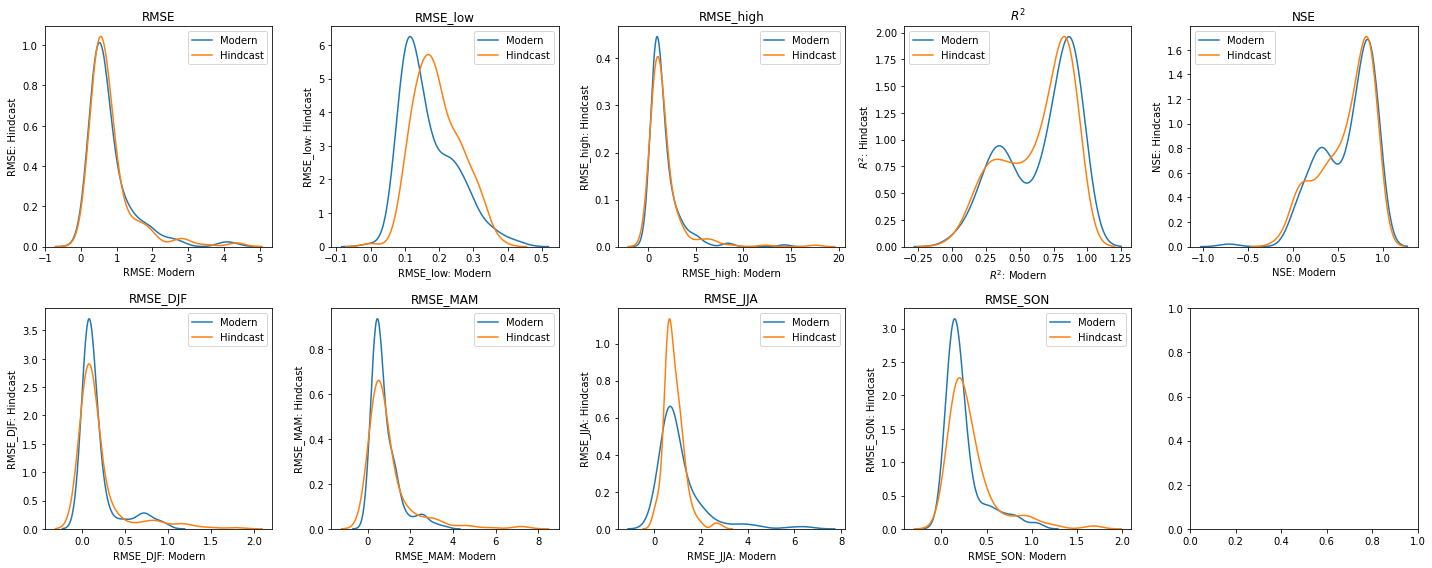

In [405]:
metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_stations]
  yy = metrics[metric][0][full_stations]

  ax = axes.flatten()[kk]

  # if metric == 'NSE':
  #   xx = xx[yy>-10]
  #   yy = yy[yy>-10]
  #   ax.scatter(xx, yy, c = cStations[full_stations][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  # else:
  #   ax.scatter(xx, yy, c = cStations[full_stations], edgecolor = 'k', linewidth = 0.75)

  sns.kdeplot(xx, ax = ax, label = 'Modern')
  sns.kdeplot(yy, ax = ax, label = 'Hindcast')

  # ax.scatter(xx, yy, c = cStations)
  # ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric + ': Modern')
  ax.set_ylabel(metric + ': Hindcast')
  ax.set_title(metric)
  ax.legend()

plt.tight_layout()

plt.show()

In [406]:
np.std(RMSE_JJA_modern), np.std(RMSE_JJA_hind)

(1.0094217712446953, 0.4339659013955139)

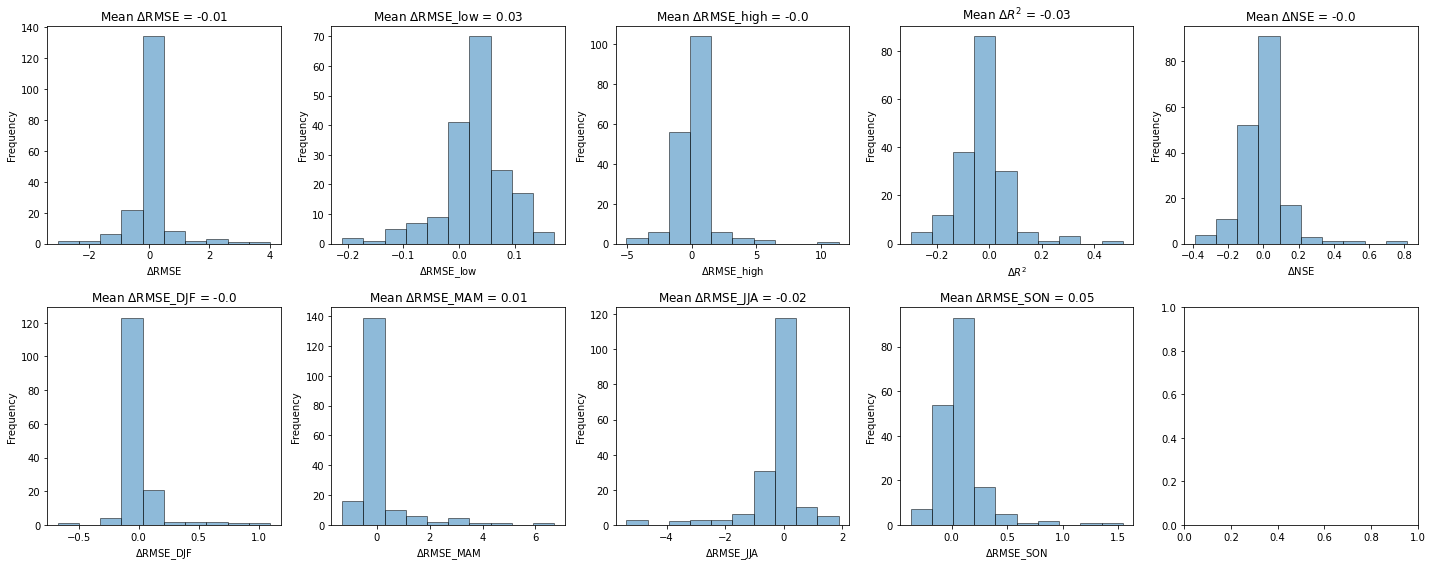

In [407]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_stations]
  # if metric == '$\Delta$NSE':
  #   xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  ax.hist(xx, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric)
  ax.set_ylabel('Frequency')
  ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)))

plt.tight_layout()

plt.show()

In [408]:
[np.argmin(dRMSE_SON)]

[30]

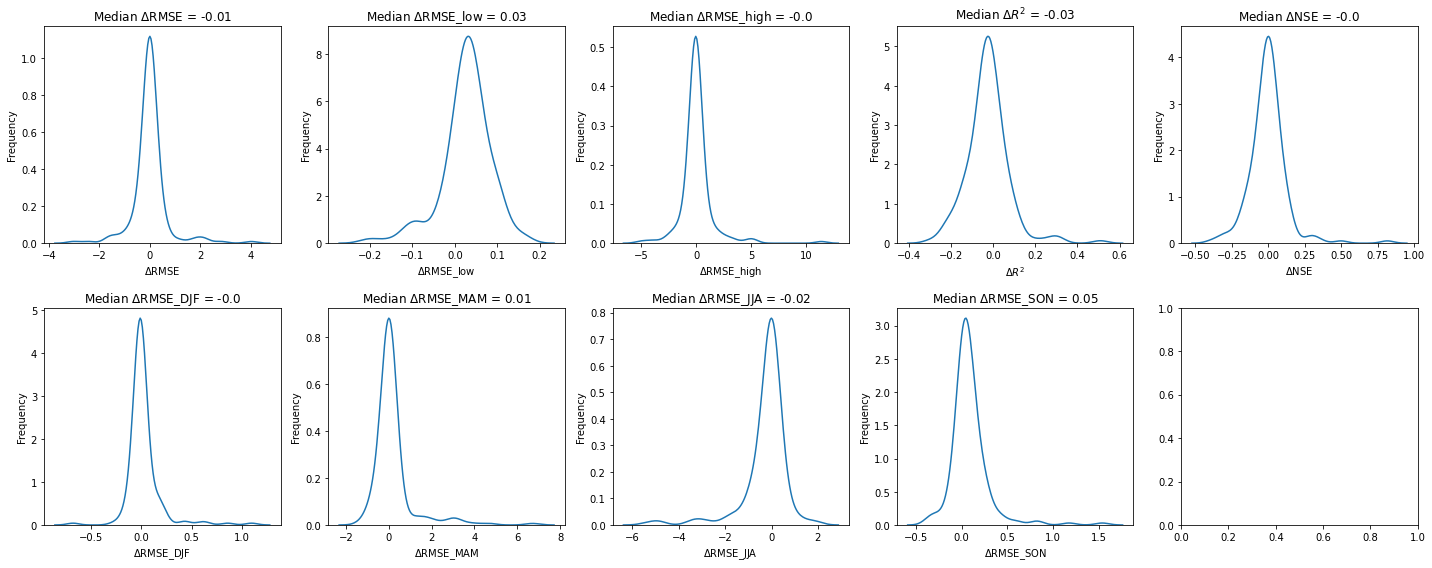

In [409]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_stations]
  if metric == '$\Delta$NSE':
    xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  sns.kdeplot(xx, ax = ax)#, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric)
  ax.set_ylabel('Frequency')
  ax.set_title('Median ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)))

plt.tight_layout()

plt.show()

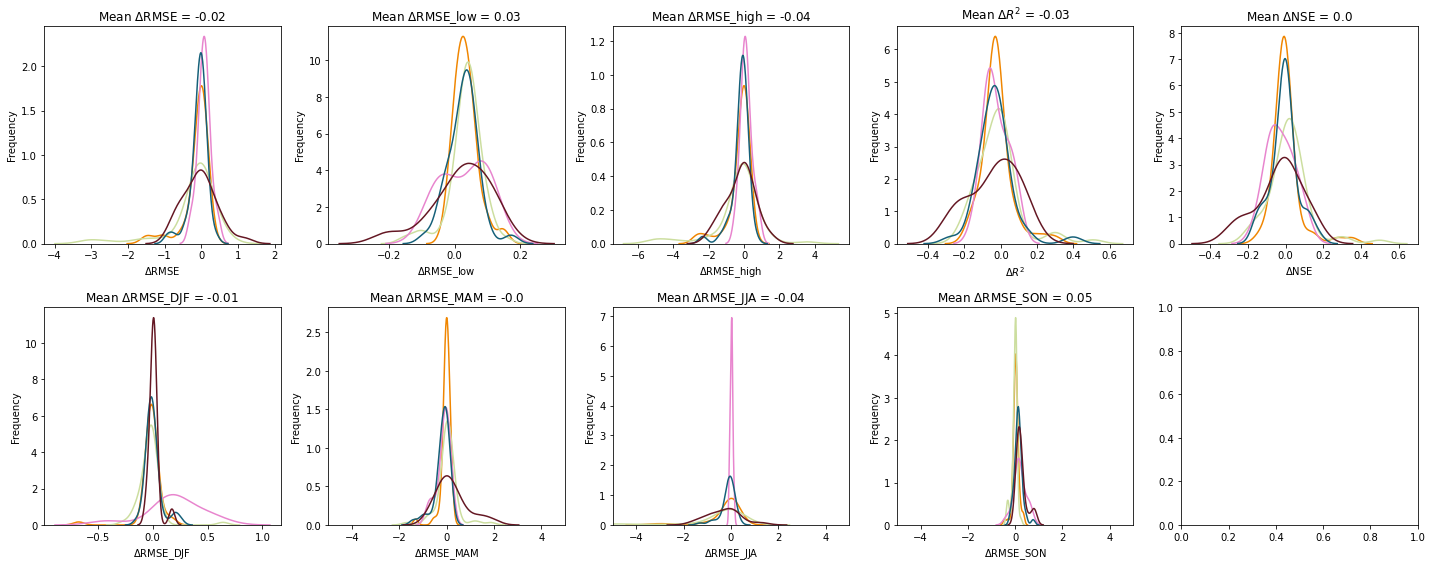

In [410]:
#compare by cluster

dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2,
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(dmetrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster in range(n_clusters_seasonal):

  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  if cluster != 2:

    for kk, metric in enumerate(dmetrics.keys()):

      xx = dmetrics[metric][cluster_inds]

      if metric == '$\Delta$NSE':
        xx = xx[xx>-10]

      ax = axes.flatten()[kk]
      # ax.hist(xx, edgecolor = 'k', alpha = 0.5, facecolor = rgbas_array[cluster,:])
      sns.kdeplot(xx, color = rgbas_array[cluster,:], ax = ax)
      ax.set_xlabel(metric)
      ax.set_ylabel('Frequency')
      ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(dmetrics[metric]), decimals = 2)))

      if (metric == '$\Delta$RMSE_MAM') | (metric == '$\Delta$RMSE_JJA') | (metric == '$\Delta$RMSE_SON'):
        ax.set_xlim((-5,5))

plt.tight_layout()

plt.show()

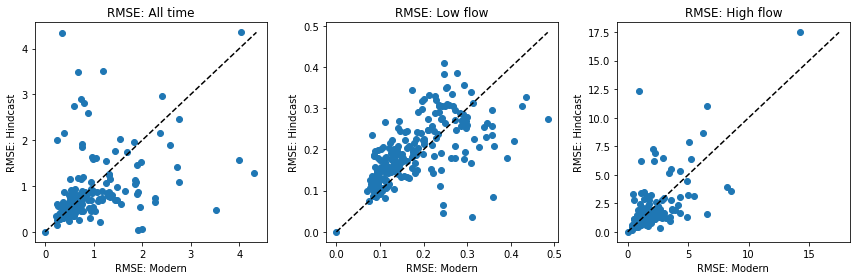

In [411]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern
yy = RMSE_hind

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern
yy = RMSE_low_hind

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern
yy = RMSE_high_hind

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

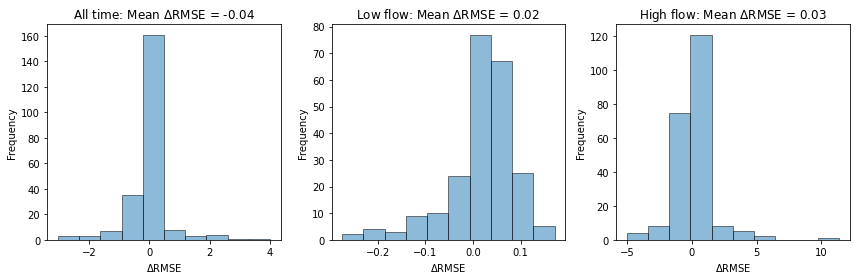

In [412]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

axes[0].hist(dRMSE, edgecolor = 'k', alpha = 0.5)
axes[0].set_xlabel('$\Delta$RMSE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('All time: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE), decimals = 2)))

axes[1].hist(dRMSE_low, edgecolor = 'k', alpha = 0.5)
axes[1].set_xlabel('$\Delta$RMSE')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Low flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_low), decimals = 2)))

axes[2].hist(dRMSE_high, edgecolor = 'k', alpha = 0.5)
axes[2].set_xlabel('$\Delta$RMSE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('High flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_high), decimals = 2)))

plt.tight_layout()

NameError: ignored

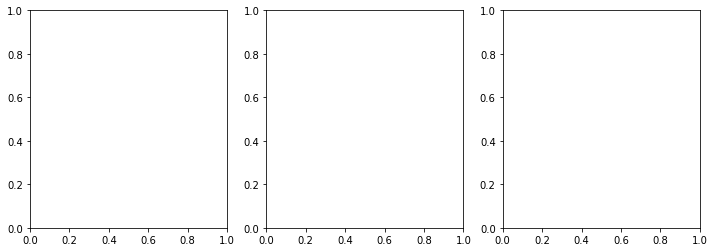

In [413]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern_norm
yy = RMSE_hind_norm

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern_norm
yy = RMSE_low_hind_norm

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern_norm
yy = RMSE_high_hind_norm

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

# Compare decadal-scale changes to seasonal

In [ ]:
y_all_predict = np.vstack([y_hind_predict, y_modern_predict])
date_all = np.vstack([np.reshape(eraDate_hind[365:], (-1,1)), np.reshape(eraDate_modern[365:], (-1,1))])

In [ ]:
np.shape(y_all_predict), np.shape(date_all)[0]

((23375, 226), 23376)

In [ ]:
for ii, kk in enumerate(range(10,15)):
  print(ii,kk)

0 10
1 11
2 12
3 13
4 14


In [ ]:
#calculate seasonal flow (365-day long flows of each year, starting on Jan 1)
delta = timedelta(days = 364)
year_start = 1951
year_fin = 2015

f_seasonal = np.zeros((365, len(stationInds)))
f_seasonal_yearly = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))

kk = 0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  if year != 1979:

    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = np.argwhere(date_all==start_date)[0][0]
    fin_ind = np.argwhere(date_all==fin_date)[0][0]

    f = y_all_predict[start_ind:fin_ind+1,:]

    if year==year_fin: #last year missing final day -- fill in with second last day
      f_new = np.zeros((365,226))
      f_new[:-1,:] = f
      f_new[-1,:] = f_new[-2,:]
      f = f_new

    f_seasonal += f
    f_seasonal_yearly[:,:,kk] = f

    kk+=1

f_seasonal /= nn


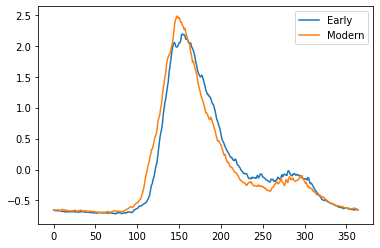

In [ ]:
ind = 7
x1 = np.mean(f_seasonal_yearly[:,:,:30], axis = -1)
x2 = np.mean(f_seasonal_yearly[:,:,-30:], axis = -1)
plt.plot(x1[:,ind], label = 'Early')
plt.plot(x2[:,ind], label = 'Modern')
plt.legend()

In [ ]:
seasonal_early = np.mean(f_seasonal_yearly[:,:,:35], axis = -1)
seasonal_modern = np.mean(f_seasonal_yearly[:,:,-35:], axis = -1)

In [ ]:
seasonal_early_clusters = np.zeros((365,n_clusters_seasonal))
seasonal_modern_clusters = np.zeros((365,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==cluster))
  seasonal_early_clusters[:,cluster] = np.mean(seasonal_early[:,inds], axis = -1)
  seasonal_modern_clusters[:,cluster] = np.mean(seasonal_modern[:,inds], axis = -1)

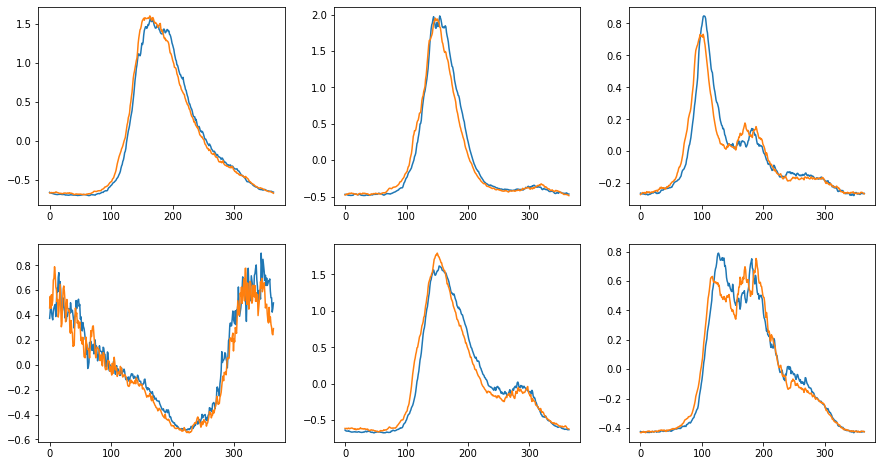

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  ax.plot(seasonal_early_clusters[:,cluster])
  ax.plot(seasonal_modern_clusters[:,cluster])

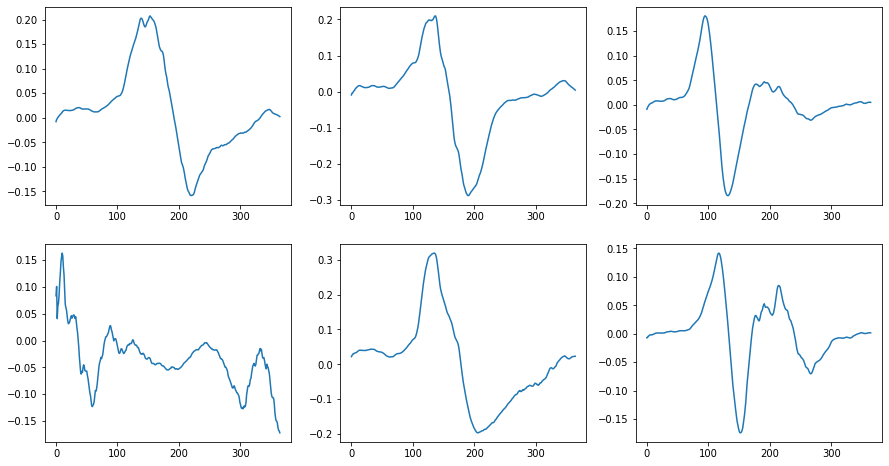

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  xx = seasonal_modern_clusters[:,cluster] - seasonal_early_clusters[:,cluster]
  ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean())
  # ax.plot(seasonal_modern_clusters[:,cluster])

In [ ]:
N_years_window = 10
start_year = 1951
fin_year = start_year + N_years_window

seasonal_window = np.zeros((365, len(stationInds), 70))

start_ind = 0
kk = 0
while fin_year <= 2015:
  seasonal_window[:,:,kk] = np.mean(f_seasonal_yearly[:,:,start_ind:start_ind+N_years_window], axis = -1)
  kk+=1
  start_ind += 1
  start_year += 1
  fin_year = start_year + N_years_window


In [ ]:
seasonal_window_clusters = np.zeros((365,n_clusters_seasonal,70))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==cluster))
  seasonal_window_clusters[:,cluster,:] = np.mean(seasonal_window[:,inds,:], axis = 1)

In [ ]:
colors = cm.get_cmap('viridis', 55)

(0.28291, 0.105393, 0.426902, 1.0)

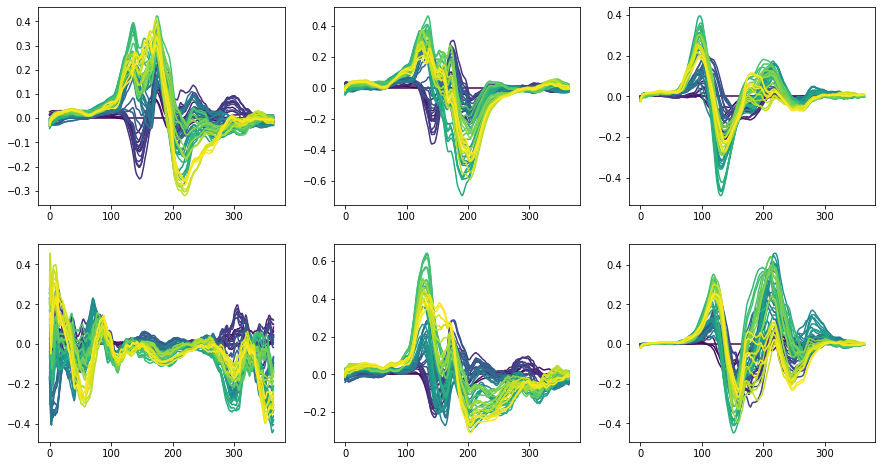

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8))

colors = cm.get_cmap('viridis', 55)

for cluster, ax in enumerate(axes.flatten()):
  for kk in range(55):
    xx = seasonal_window_clusters[:,cluster,kk] - seasonal_window_clusters[:,cluster,0]
    ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean(), color = colors(kk))

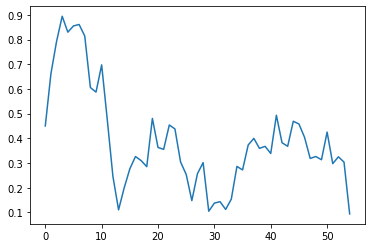

In [ ]:
day = 363
plt.plot(seasonal_window_clusters[day,3,:-15])

In [ ]:
a = np.mean(f_seasonal_yearly, axis = -1)

f_seasonal - a

array([[-1.11022302e-16,  1.11022302e-16,  1.11022302e-16, ...,
         1.11022302e-16, -1.11022302e-16,  0.00000000e+00],
       [ 2.22044605e-16,  1.11022302e-16, -5.55111512e-17, ...,
         5.55111512e-17,  1.11022302e-16,  1.38777878e-17],
       [ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, ...,
        -5.55111512e-17,  0.00000000e+00,  1.38777878e-17],
       ...,
       [ 1.11022302e-16, -1.11022302e-16,  0.00000000e+00, ...,
        -5.55111512e-17, -1.11022302e-16, -2.77555756e-17],
       [-1.11022302e-16, -1.11022302e-16, -1.11022302e-16, ...,
         5.55111512e-17,  0.00000000e+00,  0.00000000e+00],
       [ 2.22044605e-16,  1.11022302e-16,  5.55111512e-17, ...,
        -1.11022302e-16,  0.00000000e+00,  0.00000000e+00]])

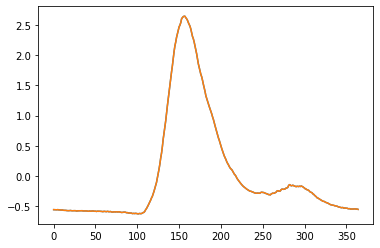

In [ ]:
plt.plot(a[:,0])
plt.plot(f_seasonal[:,0])

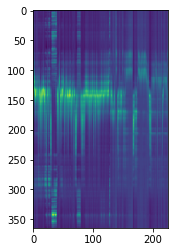

In [ ]:
plt.imshow(np.mean(f_seasonal_yearly, axis = -1))

(0.0, 365.0)

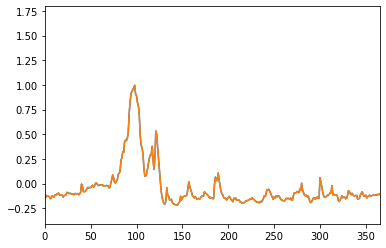

In [ ]:
plt.plot(flow)
plt.plot(y_hind_predict[:,-1])
plt.xlim((0,365))

In [ ]:
Nstations = len(stationInds)

flow_mat_all = np.zeros((Nstations, Nyears, 365))

for station in range(len(y_all_predict[0,:])):
  flow = y_all_predict[:,station]
  flow = np.asarray(pd.Series(flow).rolling(window = 30, min_periods = 1).mean())
  Nyears = int(len(flow)/365)
  flow_mat = np.zeros((Nyears, 365))
  for year in range(Nyears):
    flow_mat[year,:] = flow[year*365 : (year+1)*365]

  flow_mat_all[station,:,:] = flow_mat

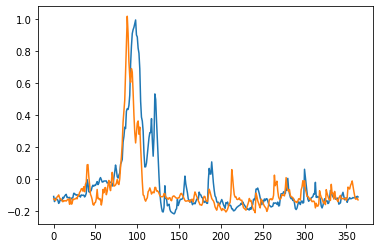

In [ ]:
plt.plot(flow_mat[0,:])
plt.plot(flow_mat[-1,:])

In [ ]:
a = np.array([0,1,1])
b = np.array([2,3,3])
np.vstack([a,b])

array([[0, 1, 1],
       [2, 3, 3]])

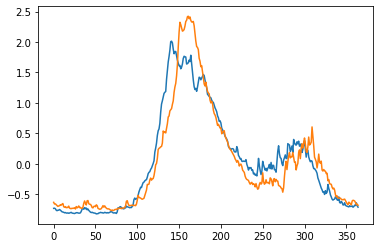

In [ ]:
ELK: 109
#BANFF: 141
#PEMBINA:
#CHEMAINUS: 31
#PEMBINA: 206
ind = 10

f1 = np.mean(flow_mat_all[ind,:20,:], axis = 0)
f2 = np.mean(flow_mat_all[ind,-20:,:], axis = 0)

fig, ax = plt.subplots()

f1 = np.mean(flow_mat_all[ind,:10,:], axis = 0)
f2 = np.mean(flow_mat_all[ind,-10:,:], axis = 0)

ax.plot(f1)
ax.plot(f2)

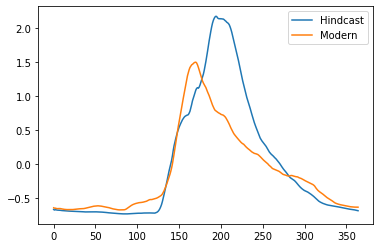

In [ ]:
ind = 141

f1 = pd.Series(y_hind_predict[:365,ind]).rolling(window = 30, min_periods = 1).mean()
f2 = pd.Series(y_modern_predict[-365:,ind]).rolling(window = 30, min_periods = 1).mean()

# f3 = pd.Series(y_modern_predict[:365,ind]).rolling(window = 30, min_periods = 1).mean()

plt.plot(f1, label = 'Hindcast')
plt.plot(f2, label = 'Modern')
plt.legend()
# plt.xlim((100,150))

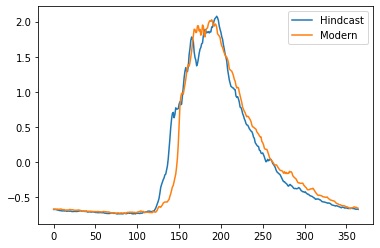

In [ ]:
ind = 141

f1 = pd.Series(y_hind_predict[:365,ind]).rolling(window = 30, min_periods = 1).mean()
f2 = pd.Series(y_modern_predict[:365,ind]).rolling(window = 30, min_periods = 1).mean()

f1 = np.mean(flow_mat_all[ind,:10,:], axis = 0)
f2 = np.mean(flow_mat_all[ind,-10:,:], axis = 0)

plt.plot(f1, label = 'Hindcast')
plt.plot(f2, label = 'Modern')
plt.legend()

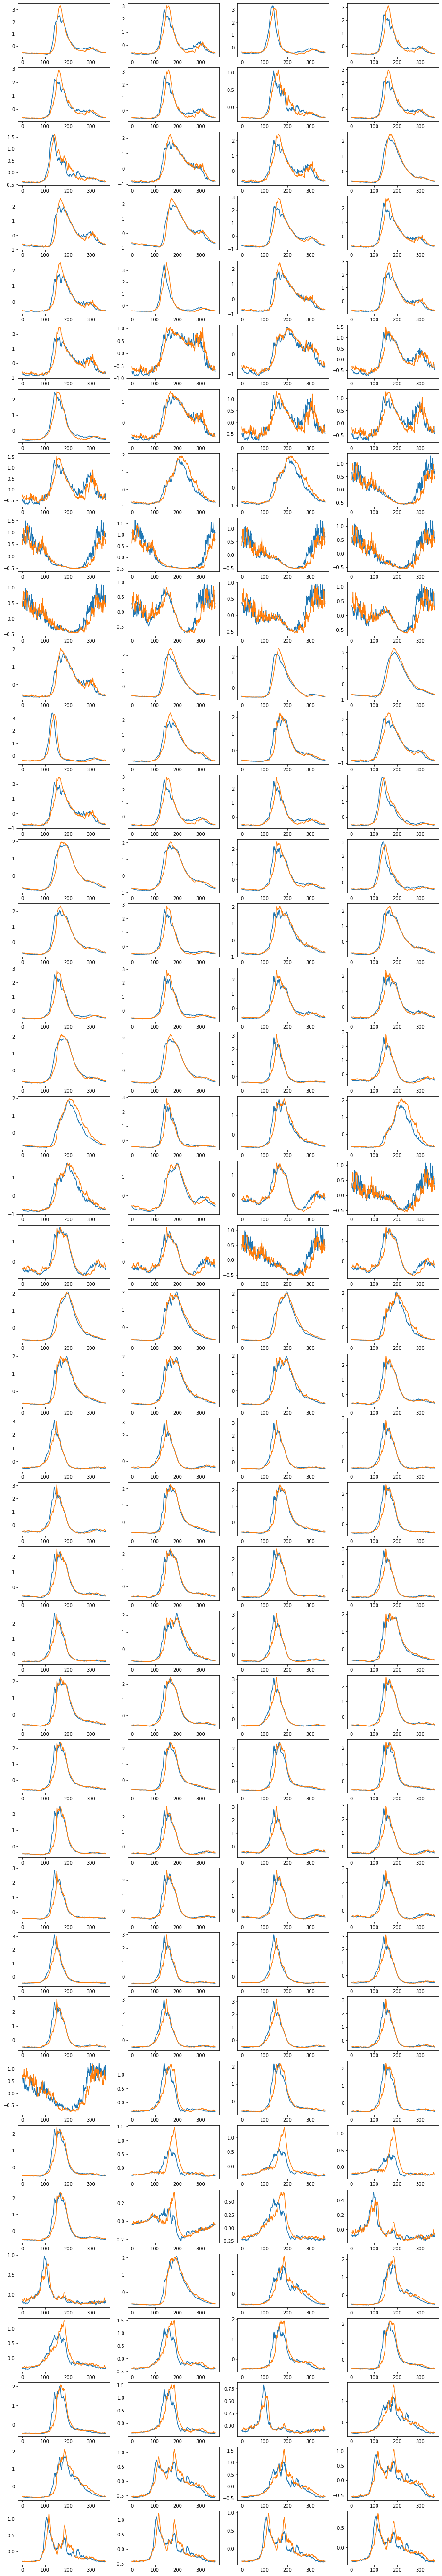

In [ ]:
# #ELK: 109
# #BANFF: 141
# #PEMBINA:
# #CHEMAINUS: 31
# #PEMBINA: 206
# ind = 10

# f1 = np.mean(flow_mat_all[ind,:20,:], axis = 0)
# f2 = np.mean(flow_mat_all[ind,-20:,:], axis = 0)

# fig, ax = plt.subplots(nrows = 40, ncols = 4, figsize = (16, 100))

# for ind, a in enumerate(ax.flatten()):

#   f1 = np.mean(flow_mat_all[ind,:10,:], axis = 0)
#   f2 = np.mean(flow_mat_all[ind,-10:,:], axis = 0)

#   a.plot(f1)
#   a.plot(f2)

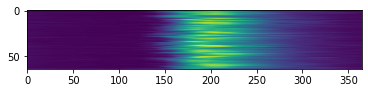

In [ ]:
plt.imshow(flow_mat_all[141])

In [ ]:
stationNames[station]

' SAGE CREEK AT Q RANCH NEAR WILDHORSE'

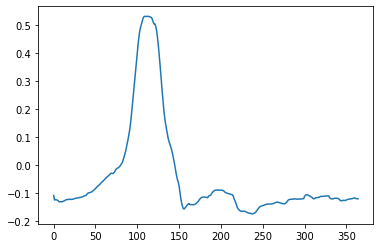

In [ ]:
plt.plot(pd.Series(flow[:365]).rolling(window = 30, min_periods = 1).mean())